<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preambles" data-toc-modified-id="Preambles-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preambles</a></span></li><li><span><a href="#Qubit-parameters" data-toc-modified-id="Qubit-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Qubit parameters</a></span></li><li><span><a href="#Rabi-like" data-toc-modified-id="Rabi-like-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Rabi-like</a></span></li><li><span><a href="#Sweep-coupling" data-toc-modified-id="Sweep-coupling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Sweep coupling</a></span></li><li><span><a href="#Chevron" data-toc-modified-id="Chevron-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Chevron</a></span></li><li><span><a href="#Calibrate-gate-time" data-toc-modified-id="Calibrate-gate-time-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Calibrate gate time</a></span></li><li><span><a href="#Gate-calibration-and-fidelity" data-toc-modified-id="Gate-calibration-and-fidelity-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Gate calibration and fidelity</a></span></li></ul></div>

# Preambles

In [146]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import qchard_coupobj as coupobj
from Fluxonium_hamiltonians import qchard_transmon as transmon
from Fluxonium_hamiltonians import qchard_pshapes as pshapes
from Fluxonium_hamiltonians import qchard_evolgates as gates
from Fluxonium_hamiltonians import qchard_evolgates_twod as gates_2d
from Fluxonium_hamiltonians import qchard_rotope as op
import plotting_settings
import scipy.linalg
from scipy.optimize import minimize
from scipy.optimize import optimize

# Qubit parameters

In [141]:
omega1 = 5.254 #GHz
omega2 = 5.331
alpha1 = -0.277
alpha2 = -0.272
nlev = 3

qubit1 = transmon.TransmonSimple(omega_q = omega1, alpha = alpha1, nlev = nlev)
qubit2 = transmon.TransmonSimple(omega_q = omega2, alpha = alpha2, nlev = nlev)
JC = 0.005 #GHz
coupling_type = 'JC-rwa'
system = coupobj.CoupledObjects(qubit1, qubit2,
    [qubit1, qubit2, JC, coupling_type])

In [169]:
#Gate parameters
shape = 'gaussflattop'
T_gate = 185 #ns
T_rise = 50
drag = False
drag_coeff = 0.0
sigma = 0.25
coupl = 62.6 #MHz
coupl_const = coupl*1e-3*2*np.pi
# coupl_const = 14
delta_omega_d = 0.03 #GHz

#Drive amplitude and frequency
omega_d1 = abs(system.freq('00', '01')) + delta_omega_d
omega_d2 = abs(system.freq('00', '10')) - delta_omega_d
print (omega_d1)
print (omega_d2)
#Evolve gate
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
H_drive1 = coupl_const * (system.a(1) + system.a(1).dag())
H_drive2 = coupl_const * (system.a(0) + system.a(0).dag())
U_t = gates_2d.evolution_operator_microwave_nonorm(
                system.H(), H_drive1, H_drive2, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, T_rise = T_rise, shape=shape, sigma=sigma, omega_d1=omega_d1,omega_d2=omega_d2)

5.361323317735609
5.223676682264391


0.04522012705193457


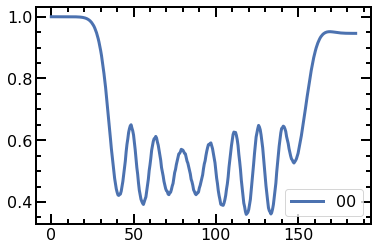

In [178]:
state_00 = system.eigvec('00')
state_01 = system.eigvec('01')
state_10 = system.eigvec('10')
state_11 = system.eigvec('11')

plt.plot(t_points, expect(state_00*state_00.dag(), U_t*state_00), label = '00')
print (1-expect(state_11*state_11.dag(), U_t*state_11)[-1])
plt.legend()

# Rabi-like 

5.331323317735609
5.253676682264391


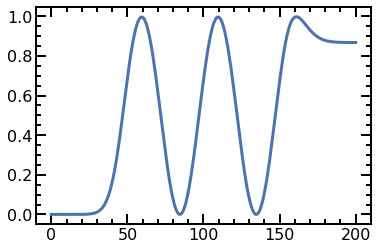

In [74]:
T_gate = 200
coupl = 20 #MHz
coupl_const = coupl*1e-3*2*np.pi
# coupl_const = 14
delta_omega_d = 0 #GHz

#Drive amplitude and frequency
omega_d1 = abs(system.freq('00', '01')) + delta_omega_d
omega_d2 = abs(system.freq('00', '10')) - delta_omega_d
print (omega_d1)
print (omega_d2)
#Evolve gate
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
H_drive1 = 0*coupl_const * (system.a(1) + system.a(1).dag())
H_drive2 = coupl_const * (system.a(0) + system.a(0).dag())
U_t = gates_2d.evolution_operator_microwave_nonorm(
                system.H(), H_drive1, H_drive2, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, T_rise = T_rise, shape=shape, sigma=sigma, omega_d1=omega_d1,omega_d2=omega_d2)

transition_00_10 = expect(state_10*state_10.dag(), U_t*state_00)
plt.plot(t_points, transition_00_10, label = '10')

# Sweep coupling

In [102]:
T_gate = 180
coupl_array = np.linspace(61,64,31)
trans_prob = np.zeros((len(coupl_array)))
for idx, coupl in enumerate(coupl_array):
    coupl_const = coupl*1e-3 * 2 *np.pi
    H_drive1 = coupl_const * (system.a(1) + system.a(1).dag())
    H_drive2 = coupl_const * (system.a(0) + system.a(0).dag())
    U_t = gates_2d.evolution_operator_microwave_nonorm(system.H(), H_drive1, H_drive2, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, T_rise = T_rise, shape=shape, sigma=sigma, omega_d1=omega_d1,omega_d2=omega_d2)
    trans_prob[idx] = expect(state_10*state_10.dag(), U_t[-1]*state_01)
            

ValueError: x and y must have same first dimension, but have shapes (31,) and (41,)

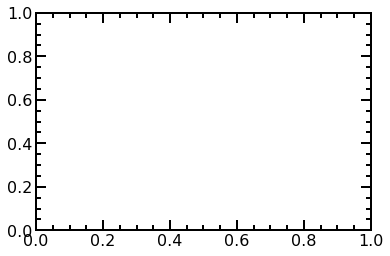

In [106]:
plt.plot(coupl_array, trans_prob)
print (coupl_array[np.argmax(trans_prob)])
print (np.max(trans_prob))
plt.xlabel('Amplitude')
plt.ylabel(r'$P_{01}$')

# Chevron

In [85]:
coupl_array = np.linspace(40,80,41)
T_gate_array = np.linspace(100,300,51)
trans_prob_chev = np.zeros((len(coupl_array), len(T_gate_array)))

for coupl_idx, coupl in enumerate(coupl_array):
    for T_idx, T_gate in enumerate(T_gate_array):
        coupl_const = coupl*1e-3 * 2 *np.pi
        t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
        H_drive1 = coupl_const * (system.a(1) + system.a(1).dag())
        H_drive2 = coupl_const * (system.a(0) + system.a(0).dag())
        U_t = gates_2d.evolution_operator_microwave_nonorm(system.H(), H_drive1, H_drive2, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
            T_gate=T_gate, T_rise = T_rise, shape=shape, sigma=sigma, omega_d1=omega_d1,omega_d2=omega_d2)
        trans_prob_chev[coupl_idx, T_idx] = expect(state_10*state_10.dag(), U_t[-1]*state_01)

In [89]:
fpath = r'/Users/longnguyen/Documents/Data/Simulation'
np.save(fpath+'/iSWAP_coupl.npy', coupl_array)
np.save(fpath+'/iSWAP_T_gate.npy', T_gate_array)
np.save(fpath+'/iSWAP_trans_prob.npy', trans_prob_chev)

1191


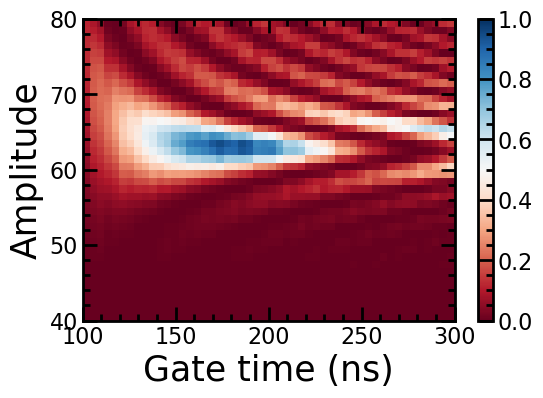

In [94]:
# coupl_array = np.load(fpath+'/iSWAP_coupl.npy')
# T_gate_array = np.load(fpath+'/iSWAP_T_gate.npy')
# trans_prob_chev = np.load(fpath+'/iSWAP_trans_prob.npy')

plt.figure(figsize = [6,4], dpi = 100)
X,Y = np.meshgrid(T_gate_array, coupl_array)
Z = trans_prob_chev
plt.pcolormesh(X,Y,Z, cmap ='RdBu', vmin = 0.2, vmax = 0.5)
plt.ylabel('Amplitude')
plt.xlabel('Gate time (ns)')
plt.colorbar()
print(np.argmax(trans_prob_chev))

# Calibrate gate time

In [143]:
coupl = 62.6 #MHz
coupl_const = coupl*1e-3*2*np.pi
delta_omega_d = 0.03 #GHz

#Drive amplitude and frequency
omega_d1 = abs(system.freq('00', '01')) + delta_omega_d
omega_d2 = abs(system.freq('00', '10')) - delta_omega_d
H_drive1 = coupl_const * (system.a(1) + system.a(1).dag())
H_drive2 = coupl_const * (system.a(0) + system.a(0).dag())

T_gate_array = np.linspace(100,300,51)
trans_prob = np.zeros((len(T_gate_array)))

for idx, T_gate in enumerate(T_gate_array): 
    #Evolve gate
    t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
    U_t = gates_2d.evolution_operator_microwave_nonorm(
                    system.H(), H_drive1, H_drive2, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                    T_gate=T_gate, T_rise = T_rise, shape=shape, sigma=sigma, omega_d1=omega_d1,omega_d2=omega_d2)
    trans_prob[idx] = expect(state_10*state_10.dag(), U_t[-1]*state_01)

184.0


Text(0, 0.5, '$P_{01}$')

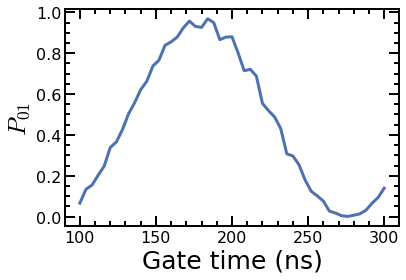

In [144]:
def cos_func(t,amp,freq,c1,c2):
    return amp*np.cos(2*np.pi*freq*(t-c1)+c2)
opt,cov = optimize(cos_func,xdata = T_gate_array, ydata = trans_prob,)
plt.plot(T_gate_array, trans_prob)
print (T_gate_array[np.argmax(trans_prob)])
plt.xlabel('Gate time (ns)')
plt.ylabel(r'$P_{01}$')

# Gate calibration and fidelity

In [148]:
coupl = 62.6 #MHz
coupl_const = coupl*1e-3*2*np.pi
delta_omega_d = 0.03 #GHz

shape = 'gaussflattop'
T_gate = 185 #ns
T_rise = 50
drag = False
drag_coeff = 0.0
sigma = 0.25

#Drive amplitude and frequency
omega_d1 = abs(system.freq('00', '01')) + delta_omega_d
omega_d2 = abs(system.freq('00', '10')) - delta_omega_d
H_drive1 = coupl_const * (system.a(1) + system.a(1).dag())
H_drive2 = coupl_const * (system.a(0) + system.a(0).dag())

#Evolve gate
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
U_t = gates_2d.evolution_operator_microwave_nonorm(
                system.H(), H_drive1, H_drive2, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, T_rise = T_rise, shape=shape, sigma=sigma, omega_d1=omega_d1,omega_d2=omega_d2)

In [168]:
U_ideal = 0
U_ideal += system.projection('00')
U_ideal += system.projection('11')
U_ideal += -1j*state_10*state_01.dag()
U_ideal += -1j*state_01*state_10.dag()

U_real = gates.change_operator_proj_subspace(system = system, U=U_t[-1])

u00 = U_real.matrix_element(state_00, state_00)
u01 = U_real.matrix_element(state_01, state_01)
u10 = U_real.matrix_element(state_10, state_10)
u11 = U_real.matrix_element(state_11, state_11)
phase1 = np.angle(u01/u00)
phase2 = np.angle(u10/u00)
phase3 = np.angle(u11*u10/(u01*u00))
print (phase1, phase2, phase3)

single_qu_z = 0
single_qu_z = single_qu_z + state_00*state_00.dag()
single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
U_real = single_qu_z * U_real

u00 = U_real.matrix_element(state_00, state_00)
u01 = U_real.matrix_element(state_01, state_01)
u10 = U_real.matrix_element(state_10, state_10)
u11 = U_real.matrix_element(state_11, state_11)
phase1 = np.angle(u01/u00)
phase2 = np.angle(u10/u00)
phase3 = np.angle(u11*u10/(u01*u00))
print (phase1, phase2, phase3)

# single_qubit_z = tensor(op.sz(-phase1,N=3), op.sz(-phase2,N=3))
op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
print (fidel)

# single_qubit_gates = gates.operator_single_qub_z(system, U_real)
# U_real = single_qubit_gates*U_real
# op1 = U_real.dag() * U_real
# op2 = U_real * U_ideal.dag()
# fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
# print (fidel)

U = gates.change_operator_proj_subspace(system = system, U=U_t[-1])
def gate_error(x):
    phase1 = x[0]
    phase2 = x[1]
    phase3 = x[2]
    phase0 = x[3]
#     single_qubit_z = tensor(op.sz(phase1,N=3), op.sz(phase2,N=3))
    single_qu_z = 0
    single_qu_z = single_qu_z + state_00*state_00.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
    single_qu_z = single_qu_z + np.exp(-1j*(phase1+phase2-phase3))*state_11*state_11.dag()
    U_real = single_qu_z * U 
    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
    return (fidel)

x0 = [1,1,1,0] #guess
xopt = minimize(gate_error, x0, method ='Powell', tol = None)
fidelity = 1.0-gate_error(xopt.x)
print (fidelity)

1.161873765055369 -0.5145492024991902 -1.2635949774215836
6.336698790190288e-17 -6.014041580000883e-17 -0.23449657242320332
0.72006738266235
0.8000040876430502


In [ ]:
# 8 